# This script estimate the system sensitivity as a function of the off-axis angle for a given camera geometry and mask code
The function `snr_vs_off_axis` in `mask_utils.imaging_utils` makes use of $eq. 13$ and $eq. 23$ from G. K. Skinner - _"The sensitivity of coded mask telescopes"_ (2008)

In [1]:
%matplotlib ipympl
import numpy as np
import sys

# setting path for mask_utils package
sys.path.append('..')

from mask_utils.imaging_utils import snr_vs_off_axis, solid_angle
from mask_utils.fits_utils import read_mask_bulk

import matplotlib.pyplot as plt

## Reading mask and bulk FITS files

In [2]:
mask_file = "F:/CodedMasks/mask_050_1040x17/mask_050_1040x17_20250710.fits"
#mask_file = "F:/LEM-X/IROS/wfm_mask.fits"
mask, hdmask = read_mask_bulk(mask_file, 'MASK', header_out=True, verbose=False)
bulk = read_mask_bulk(mask_file, 'SENS', verbose=False)

## Gettin mask and bulk properties

In [3]:
mask_x_pitch = hdmask['DXSLIT']
mask_y_pitch = hdmask['DYSLIT']
ELXDIM = hdmask['ELXDIM']
ELYDIM = hdmask['ELYDIM']
OPENFR = hdmask['OPENFR']
det_x_pitch = 0.080 #Standard spatial resolution
mask_thickness = 0.150
focal = 202.9

## Estimating Crab and CXB counts considering eXTP/WFM simulations

In [4]:
omega = solid_angle(bulk, ELXDIM, ELYDIM, focal, nobulk=True)

In [5]:
s_counts = 1.85* (OPENFR/0.215799) #Crab rate on-axis pre-mask, rescaled from WFM sims

cxb = 5.2 # counts cm-2 sr-1 pre mask
b_counts = cxb * np.max(omega) * OPENFR
print("Src/bkg counts cm2 s-1:", s_counts, b_counts)
print("CXB counts per pixel in 10ks:", b_counts * ((ELXDIM * ELYDIM)/100) * 10E3) # CXB counts per pixel in 10ks


Src/bkg counts cm2 s-1: 3.760608317434905 2.702043734014562
CXB counts per pixel in 10ks: 33.77554667518203


## Generating coordinates grid

In [6]:
thetaX = np.linspace(-40, 40, 33)
thetaY = np.linspace(-40, 40, 33)
theta = np.meshgrid(thetaX, thetaY)

## Calculating 5$\sigma$ sensitivity in 1 s, expressed in mCrab

In [7]:

sensMap_x = [1000 / ( snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, theta, 0, degrees=True)/5) for theta in thetaX]
sensMap_y = [1000 / ( snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, 0, theta, degrees=True)/5) for theta in thetaY]

peak_snr = np.sqrt(1000) * snr_vs_off_axis(s_counts, b_counts, mask, bulk, mask_x_pitch, mask_y_pitch, ELXDIM, ELYDIM, det_x_pitch, focal, mask_thickness, 0, 0, degrees=True)

print ("1ks expected Crab significance (on-axis):", int(peak_snr))

1ks expected Crab significance (on-axis): 333


## Plotting results

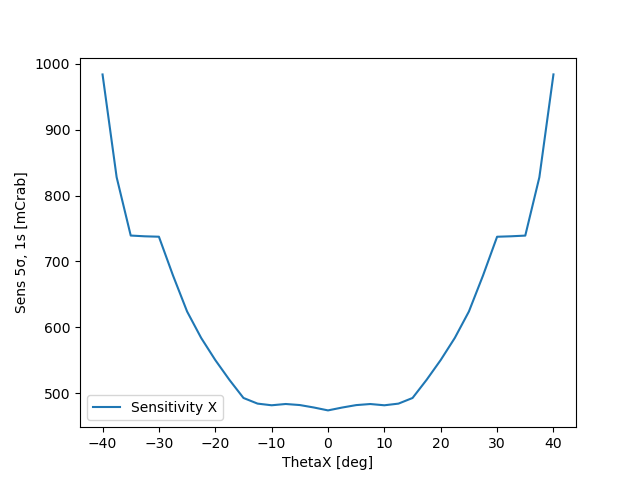

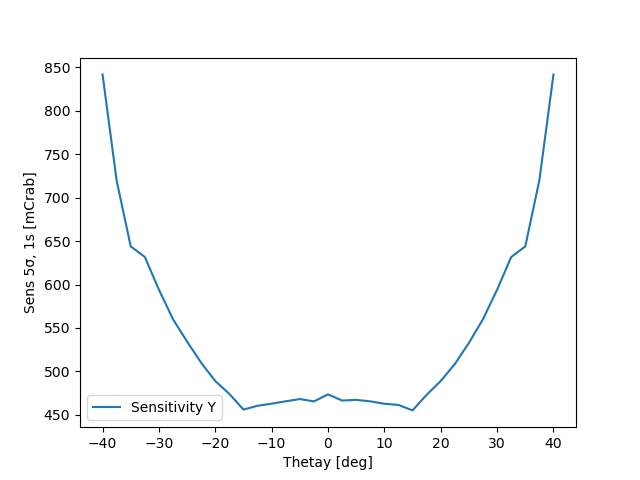

In [8]:
plt.figure()
plt.plot(thetaX, sensMap_x, label="Sensitivity X")
plt.xlabel("ThetaX [deg]")
plt.ylabel("Sens 5σ, 1s [mCrab]")
plt.legend()
plt.show()

plt.figure()
plt.plot(thetaY, sensMap_y, label="Sensitivity Y")
plt.xlabel("Thetay [deg]")
plt.ylabel("Sens 5σ, 1s [mCrab]")
plt.legend()
plt.show()
